## O dataset

No dataset que iremos trabalhar hoje, teremos o número de vendas mensais de um shampoo durante o período de 3 anos.

As unidades são basicamente contagens de vendas no período de 3 anos (são 36 observações). O dataset original é creditao a Makridakis, Wheelwright, and Hyndman (1998).

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales, dtype: float64


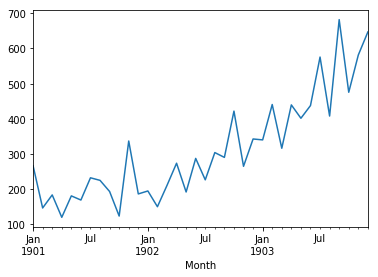

In [1]:
#load libs
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot

# load dataset
def parser(x):
    #Parsing de Data
    return datetime.strptime('190'+x, '%Y-%m')

series = read_csv('../data/shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# summarize first few rows
print(series.head())
# line plot
series.plot()
pyplot.show()
#Numero de vendas dia a dia

Vamos dividir nossos dados em treino e teste, mantendo a ordem já que estamos lidando com dados temporais.

Os dois primeiros dados serão usados para treinamento, enquanto o utlimo ano será usado para validação.

In [2]:
# split data into train and validation
X = series.values
train, val = X[0:-12], X[-12:]

Para os nossos dados de teste, usaremos uma espécie de "rolamento". O modelo fará a predição para o momento `t`, então o valor real esperado do conjunto de teste será "pego" e ficará disponível para o modelo usar para fazer a predição do próximo passo.

Isso imita o cenário real porquê teríamos os valores reais a medida que os meses forem passando.

Por fim, todas as previsões nos dados de teste serão coletadas e o erro será calculado para resumir a qualidade do modelo. Usaremos aqui o RMSE (root mean squared error) uma vez que ele coloca um peso maior em erros muito distantes do real e seu resultado é no mesmo número de unidades que estamos usando (shampoo).

### Primeiro, um baseline (Zero Rule Learning)

Vamos tentar um modelo simples, apenas uma abordagem de senso comum. Ela servirá como um "teste de sanidade" e servirá para estabelecermos um baseline cujo modelo que estamos batendo têm que derrotar. Esse tipo de abordagem é útil quando estamos atacando um problema que não temos a solução. 

Alguns exemplos:
    - Sempre chutar a classe mais predominante (problemas de classificação)
    - Fazer uma média dos valores (regressão)
    
Como estamos trabalhando com uma timeseries de vendas. Nós podemos assumir que tais dados são contínuos (as vendas de amanhã devem ser parecidas com a venda de hoje, com algum desvio padrão). Um approach bem comum é fazer com que as vendas do próximo mês sejam exatamente iguais às vendas do mês atual.

RMSE: 136.761


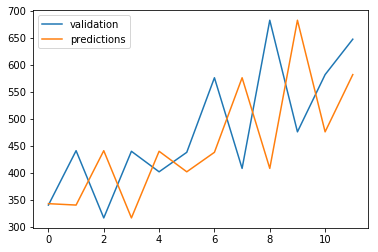

In [3]:
from pandas import read_csv
from pandas import datetime
import pandas as pd
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot
# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
series = read_csv('../data/shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# split data into train and test
X = series.values
train, val = X[0:-12], X[-12:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(val)):
	# make prediction
	predictions.append(history[-1])
	# observation
	history.append(val[i])
# report performance
rmse = sqrt(mean_squared_error(val, predictions))
print('RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(val)
pyplot.plot(predictions)
pyplot.legend({'validation': val, 'predictions': predictions})
pyplot.show()

## Transformando em um problema de aprendizado surpervisionado

Para a observação no tempo `t`, preveja a observação no tempo `t+1`.

In [4]:
df = pd.DataFrame(series)
columns = [df.shift(i) for i in range(1, 1+1)]
columns[0].head()
columns.append(df)
df = pd.concat(columns, axis=1) #mergeando os dois dataframes em um só
df.head()

,Sales,Sales
Month,,
1901-01-01,NaN,266.0
1901-02-01,266.0,145.9
1901-03-01,145.9,183.1
1901-04-01,183.1,119.3
1901-05-01,119.3,180.3


In [5]:
df.fillna(0, inplace=True)

## Temos que transormar os dados em Estacionários !

O dataset que estamos trabalhando nnao é estacionário.

Isso significa que há uma estrutura nos dados que é dependende do tempo. Especificamente falando, vemos uma tendência/sazonalidade dos dados. Não conseguimos prever isso e isso não é legal para o modelo !

Essa tendência pode ser removida das observações e então adicionadas mais tardes para as previsões, em escala original e calculando um erro comparável.

Uma forma simples de remover calcular essa diferença. Ou seja, a observação no timestamp anterior (t-1) subtraída à observação atual (t). Nos vamos ter as diferenças e vamos trabalhar em cima delas.

In [6]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

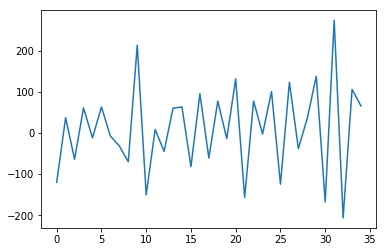

In [7]:
differenced = difference(series)
pyplot.plot(differenced)
pyplot.show()

E aí pra voltar


In [8]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

In [9]:
# invert transform
inverted = list()
for i in range(len(differenced)):
	value = inverse_difference(series, differenced[i], len(series)-i)
	inverted.append(value)
inverted = pd.Series(inverted)
print(inverted.head())

0    145.9
1    183.1
2    119.3
3    180.3
4    168.5
dtype: float64


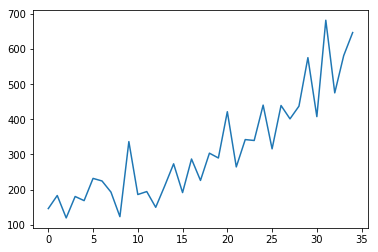

In [10]:
pyplot.plot(inverted)
pyplot.show()

As redes neurais no geral precisam que os dados estegam em uma escala que varia entre 0 e 1 (ou -1 e 1) por conta das funções de ativação.

In [11]:
from sklearn.preprocessing import MinMaxScaler
# transform scale
X = series.values
X = X.reshape(len(X), 1)
scaler = MinMaxScaler(feature_range=(0, 1)) #for relu
scaler = scaler.fit(X)
scaled_X = scaler.transform(X)

In [12]:
# invert transform
inverted_X = scaler.inverse_transform(scaled_X)

## Juntando tudo o que temos agora

In [57]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy
from tqdm import tqdm

# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an network to training data
def fit(train,batch_size, nb_epoch, neurons,val):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], X.shape[1])
    X_val, y_val = val[:, 0:-1], val[:, -1]
    n_cols = X.shape[1]
    model = Sequential()
    model.add(Dense(neurons, input_shape=(n_cols,)))
    model.add(Dense(1))
    print (model.summary())
    model.compile(loss='mean_squared_error', optimizer='adam')
    history = model.fit(X, y, epochs=nb_epoch, batch_size=batch_size, verbose=0, shuffle=False, validation_data=(X_val,y_val))
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    pyplot.figure()

    pyplot.plot(epochs, loss, 'bo', label='Training loss')
    pyplot.plot(epochs, val_loss, 'b', label='Validation loss')
    pyplot.title('Training and validation loss')
    pyplot.legend()
    pyplot.show()
    
    return model

# make a one-step forecast
def forecast(model, batch_size, X):
	X = X.reshape(1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 4)                 8         
_________________________________________________________________
dense_52 (Dense)             (None, 1)                 5         
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________
None


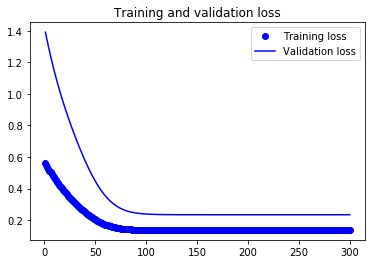

100%|██████████| 12/12 [00:00<00:00, 898.43it/s]


Month=1, Predicted=291.698952, Expected=339.700000
Month=2, Predicted=342.688881, Expected=440.400000
Month=3, Predicted=374.535162, Expected=315.900000
Month=4, Predicted=400.140258, Expected=439.300000
Month=5, Predicted=358.304689, Expected=401.300000
Month=6, Predicted=427.884437, Expected=437.400000
Month=7, Predicted=414.593731, Expected=575.500000
Month=8, Predicted=484.706521, Expected=407.600000
Month=9, Predicted=520.768158, Expected=682.000000
Month=10, Predicted=500.356958, Expected=475.300000
Month=11, Predicted=614.329961, Expected=581.300000
Month=12, Predicted=511.902509, Expected=646.900000


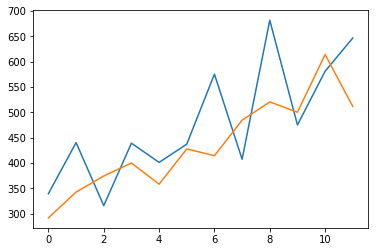

Test RMSE: 89.693


In [60]:
# load dataset
series = read_csv('../data/shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)
# fit the model
model = fit(train_scaled, 3, 300, 4, test_scaled)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1)
model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()
for i in tqdm(range(len(test_scaled))):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast(model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

# report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
# line plot of observed vs predicted
pyplot.plot(raw_values[-12:])
pyplot.plot(predictions)
pyplot.show()

print('Test RMSE: %.3f' % rmse)